# Classificação para Proposições da Câmara dos Deputados

Projetos de leis e propostas de emendas à Constituição (PECs) são provavelmente os mais conhecidos produtos das atividades parlamentares. Mas também são proposições alguns outros tipos de documentos legislativos: pareceres sobre outras proposições, requerimentos, relatórios de CPIs, medidas provisórias do poder Executivo e emendas ao Orçamento da União, apenas para citar alguns.

Este trabalho têm objetivo de utilizar a base de proposições da Câmara dos Deputados para treinar um modelo de Classificação que possa prever se um projeto ainda não aprovado têm probabilidade de ser aprovado.

Para isso, trabalharemos apenas com os seguintes tipos de proposições da base:
- Projetos de leis;
- Emendas à constituição (PECs).

No final, pretende-se que, ao apresentar um projeto de lei ou emenda à constituição ainda não aprovado, o modelo diga se poderá obter aprovação.

Repositório no GitHub [aqui](https://github.com/edprata/proposicoes_camara_deputados/tree/main). Notebook no Colab com versão resumida (sem Pycaret) [aqui](https://colab.research.google.com/drive/1B_S3saTPfT5_CxrH0UZYkJ78bgilt8sb).

## Instalações e imports

Instalações e imports de bibliotecas utilizadas em todo código.

### Instalação dos pacotes

In [1]:
%pip install --upgrade pip
%pip install pycaret
%pip install nbimporter
%pip install libomp
%pip install lightgbm
%pip install keras
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement libomp (from versions: none)
ERROR: No matching distribution found for libomp
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packa

### Imports das bibliotecas

In [2]:
import pandas as pd
import numpy as np
import nbimporter
import lib_llama_ml as llama
import tensorflow

from pycaret.classification import *
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import activations

/Users/edprata/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Carregamento da Base

Carregamento da base de dados que será utilizada para o trabalho de classificação.

In [3]:
lista_preposicoes = [
    pd.read_csv('/Users/edprata/Downloads/Bases/proposicoes-2020.csv', sep=';', on_bad_lines='skip'),
    pd.read_csv('/Users/edprata/Downloads/Bases/proposicoes-2021.csv', sep=';', on_bad_lines='skip'),
    pd.read_csv('/Users/edprata/Downloads/Bases/proposicoes-2022.csv', sep=';', on_bad_lines='skip')
]

lista_autores = [
    pd.read_csv('/Users/edprata/Downloads/Bases/proposicoesAutores-2020.csv', sep=';'),
    pd.read_csv('/Users/edprata/Downloads/Bases/proposicoesAutores-2021.csv', sep=';'),
    pd.read_csv('/Users/edprata/Downloads/Bases/proposicoesAutores-2022.csv', sep=';')
]

proposicoes_raw = pd.concat(lista_preposicoes)
autores_raw = pd.concat(lista_autores)

print(proposicoes_raw.shape)
print(autores_raw.shape)

(96439, 21)
(175804, 12)


## Análise Exploratória

A seguir será feita uma análise exploratória para conhecimento dos dados, posterior tratamento deste dados (higienização) e também para seleção de features úteis ao problema.

### Conhecendo as colunas

Veremos quais colunas as bases apresentam para entender seu significado e como podem ser utilizadas. Além disso, precisamos saber qual coluna utilizar para identificar as Proposições e incluir dados da base de autores, formando uma só base.

In [4]:
proposicoes_raw.columns

Index(['id', 'siglaTipo', 'numero', 'ano', 'codTipo', 'descricaoTipo',
       'ementa', 'keywords', 'dataApresentacao', 'uriOrgaoNumerador',
       'ultimoStatus_dataHora', 'ultimoStatus_sequencia',
       'ultimoStatus_idOrgao', 'ultimoStatus_siglaOrgao',
       'ultimoStatus_regime', 'ultimoStatus_descricaoTramitacao',
       'ultimoStatus_idTipoTramitacao', 'ultimoStatus_descricaoSituacao',
       'ultimoStatus_idSituacao', 'ultimoStatus_despacho',
       'ultimoStatus_apreciacao'],
      dtype='object')

In [5]:
proposicoes_raw.iloc[1]

id                                                                            2077498
siglaTipo                                                                          PL
numero                                                                           1600
ano                                                                              2020
codTipo                                                                           139
descricaoTipo                                                          Projeto de Lei
ementa                              Altera a Lei nº 8.069, de 13 de julho de 1990,...
keywords                            Alteração, Estatuto da Criança e do Adolescent...
dataApresentacao                                                  2016-02-18T12:56:57
uriOrgaoNumerador                   https://dadosabertos.camara.leg.br/api/v2/orga...
ultimoStatus_dataHora                                             2021-11-04T00:00:00
ultimoStatus_sequencia                                

In [6]:
autores_raw.columns

Index(['idProposicao', 'uriProposicao', 'idDeputadoAutor', 'uriAutor',
       'codTipoAutor', 'tipoAutor', 'nomeAutor', 'siglaPartidoAutor',
       'uriPartidoAutor', 'siglaUFAutor', 'ordemAssinatura', 'proponente'],
      dtype='object')

In [7]:
autores_raw.iloc[1]

idProposicao                                                   2469552
uriProposicao        https://dadosabertos.camara.leg.br/api/v2/prop...
idDeputadoAutor                                                    NaN
uriAutor             https://dadosabertos.camara.leg.br/api/v2/orga...
codTipoAutor                                                     40000
tipoAutor                                   Órgão do Poder Legislativo
nomeAutor                           Senado Federal - Alessandro Vieira
siglaPartidoAutor                                                  MDB
uriPartidoAutor                                                    NaN
siglaUFAutor                                                        SE
ordemAssinatura                                                      1
proponente                                                           1
Name: 1, dtype: object

### Explorando colunas com potencial

Após observar quais são as colunas disponíveis, vamos explorar melhor aquelas que parecem mais promissoras, principalmente as que possuem dados categóricos, para conhecer o domínio destes campos e descobrir seu potencial de utilização.

#### Identificando ID da Proposição

Vamos precisar encontrar o identificador único da Proposição, pois será necessário cruzar com a base de autores e também encontrar o último estado de cada Proposição, pois a base apresenta, na verdade, as várias tramitações de cada uma durante seu ciclo de vida.

In [8]:
proposicoes_raw.columns

Index(['id', 'siglaTipo', 'numero', 'ano', 'codTipo', 'descricaoTipo',
       'ementa', 'keywords', 'dataApresentacao', 'uriOrgaoNumerador',
       'ultimoStatus_dataHora', 'ultimoStatus_sequencia',
       'ultimoStatus_idOrgao', 'ultimoStatus_siglaOrgao',
       'ultimoStatus_regime', 'ultimoStatus_descricaoTramitacao',
       'ultimoStatus_idTipoTramitacao', 'ultimoStatus_descricaoSituacao',
       'ultimoStatus_idSituacao', 'ultimoStatus_despacho',
       'ultimoStatus_apreciacao'],
      dtype='object')

In [9]:
len(proposicoes_raw['id'].unique())

96439

**Resultado:** O campo ID, que parecia ser o identificador único da proposição, não têm esse papel, pois a quantidade de valores únicos desta coluna é igual a quantidade total de linhas do conjunto de dados, porém é conhecido que existe repetições.

In [10]:
len(proposicoes_raw['numero'].unique())

5468

**Resultado:** Ao testar um outro campo promissor, o "número", nos parece mais plausível que possa identificar unicamente uma Proposição. Dividindo o total de linhas do conjunto pela quandidade de elementos únicos da coluna (313090 / 11277), temos cerca de 27 linhas para cada Proposição. Porém, este número parece grande, considerando-se que o ciclo de vida não deve ter tantas fases. Portanto, vamos avaliar melhor esta hipótese.

In [11]:
len((proposicoes_raw['ano'].astype(str) + proposicoes_raw['numero'].astype(str)).unique())

12576

**Resultado:** Ao verificar a quantidade de elementos únicos juntando o ano com o número, constatamos uma quantidade bem maior de Proposições, o que nos revela que a numeração reinicia a cada ano. Desta forma, para identificar unicamente uma Proposição, vamos precisar do ano e do número juntos. Mais adiante, vamos criar uma nova coluna com este dado para facilitar a manipulação da base e o cruzamento de dados.

#### Identificando estados de sucesso e fracasso

Precisamos descobrir quais estados representam sucesso e fracasso, ou seja, aprovação e reprovação, para, posteriormente, criarmos uma variável alvo que indique quais Proposições obtiveram sucesso e quais não. Vamos listar os valores únicos do campo "ultimoStatus_descricaoTramitacao" para avaliar os resultados e selecionar os valores de interesse para o problema.

In [12]:
tipos_tramitacoes = proposicoes_raw['ultimoStatus_descricaoTramitacao'].unique()
print(tipos_tramitacoes.size)
tipos_tramitacoes

85


array(['Apresentação de Proposição', 'Publicação de Proposição',
       'Arquivamento', 'Ratificação de Parecer', 'Recebimento',
       'Análise Parecer', 'Transformação em Norma Jurídica',
       'Recebimento - Relator(a)', 'Apresentação de Requerimento',
       'Publicação de Despacho',
       'Saída de Relator(a) da Comissão - Com Parecer Apresentado',
       'Saída de Relator(a) da Comissão - Sem Parecer Apresentado',
       'Parecer do(a) Relator(a)', 'Notificação de Apensação',
       'Notificações', 'Transformado em Norma Jurídica com Veto Parcial',
       'Encerramento de Prazo', 'Designação de Relator(a)',
       'Encaminhamento', 'Sessão Solene',
       'Aprovação de Proposição Interna', 'Distribuição',
       'Recebimento - Relator(a) (Sem Manifestação)',
       'Arquivamento - Art.133 do RI', 'Despacho de Apensação',
       'Notificação de Despacho', 'Devolução à CCP', 'Apensação',
       'Aprovação de Proposição (Plenário)',
       'Aprovação de Urgência (154, 155 ou 64 CF

**Resultado:** Foram identificados como estados que representam o sucesso da Proposição, ou seja, sua aprovação pelo congresso, os destacados no código abaixo. Esses estados serão separados em um array para posterior utilização. Embora caiba algumas questões posteriores, como veto presidencial, por exemplo, o escopo deste trabalho é medir a possibilidade de aprovação no congresso. Logo, vamos considerar sucesso toda preposição que passou deste ponto.

In [13]:
estados_sucesso = [
    'Aprovação',
    'Aprovação da Redação Final',
    'Publicação de Documento', # o documento é publicado após aprovado
    'Leitura e publicação', # o documento é publicado após aprovado
    'Publicação de Proposição', # a proposição é publicada após aprovada
    'Transformação em Norma Jurídica', # dependendo da proposição, sua conclusão é a transformação em norma jurídica
    'Transformado em Norma Jurídica com Veto Parcial', # idem anterior
    'Recebimento - Redação Final', # a redação final é realizada após a proposição ser aprovada
    'Dispensada a Redação Final' # alguns documentos dispensão a redação final por não haver necessidade de correções
]

estados_fracasso = [
	'Arquivamento',
	'Retirada pelo(a) Autor(a)',
	'Arquivamento - Art.133 do RI',
	'Deferido o requerimento de retirada pelo(a) autor(a)',
	'Rejeição de Proposicao',
	'Transformada em Nova Proposição',
	'Vetado Totalmente',
	'Prejudicado Requerimento', 
	'Não Acolhimento',
	'Prejudicialidade (Plenário)',
	'Perda de eficácia',
	'Rejeição de Proposição (Plenário)',
	'Retirada pelo Autor(a) (Plenário)'
]

#### Identificando tipos de autores

Por se tratar de um assunto que envolve política, o autor da Proposição pode exercer influência no seu destino. Por este motivo, vamos listar o conteúdo do campo e conhecer os valores possíveis.

In [14]:
autores_raw['tipoAutor'].unique()

array(['Órgão do Poder Legislativo', 'COMISSÃO DIRETORA', 'Deputado(a)',
       'Órgão do Poder Executivo', 'Senador(a)', 'COMISSÃO PERMANENTE',
       'Sociedade Civil', 'COMISSÃO PARLAMENTAR DE INQUÉRITO',
       'COMISSÃO EXTERNA', 'Liderança',
       'MPU - Ministério Público da União', 'COMISSÃO MEDIDA PROVISÓRIA',
       'COMISSÃO MISTA PERMANENTE', 'Órgão da Câmara dos Deputados',
       'COMISSÃO ESPECIAL', 'Órgão do Poder Judiciário',
       'GRUPO DE TRABALHO', 'SUBCOMISSÃO',
       'DPU - Defensoria Pública da União', 'CONSELHO',
       'Partido Político', 'PERMANENTE DO SENADO FEDERAL'], dtype=object)

**Resultado:** Podemos observar alguns que há várias fontes possíveis de autoria das Proposições. A fonte talvez tenha influência no processo decisório, pode ser que uma instituição tenha mais presítigio que outra. É uma hipótese interessante a ser verificada na análise descritiva mais adiante.

## Inclusão dos Autores

Como trata-se de um assunto que envolve política, certamente o autor da proposição pode influenciar na avaliação desta e na sua consequente aprovação ou não. Por esse motivo, vamos incluir esse dados na base, a fim de usar como uma feature do problema mais à frente.

### Filtragem do primeiro signatário

Segundo o Portal de Dados Abertos, na página de arquivos da Câmara dos Deputados, a base de autores pode possuir mais de uma linha para cada Proposição, pois, pelo Regimento da Câmara, todos os que assinam uma proposição são considerados autores (art. 102), tanto como proponentes quanto como apoiadores. Porém, apenas o primeiro signatário pode escrever a justificativa (art. 102) e falar sobre a proposição durante votações (art. 192).

Por este motivo, também a fim de simplificar o problema, vamos considerar para utilização no modelo apenas o primeiro signatário. Sendo ele quem pode falar sobre a proposição durante as votações, certamente é o que pode exercer mais influência sobre o resultado da mesma.

In [15]:
autores = autores_raw[autores_raw['ordemAssinatura'] == 1]
autores.shape

(97166, 12)

**Resultado:** Após filtrar os registros da base de autores pelo primeiro signatário, observamos que a quantidade de linhas caiu de 642.557 para menos da metade. O que confirma a informação que consta na página já citado de que é comum haver vários autores para cada proposição.

### Cruzamento da base de proposições com a de autores

Agora vamos cruzar as bases de proposições e autores a fim de acrescentar a informação do autor e obter uma base completa.

In [16]:
proposicoes = pd.merge(
    proposicoes_raw,
    autores[['idProposicao', 'idDeputadoAutor', 'nomeAutor', 'codTipoAutor', 'tipoAutor', 'siglaPartidoAutor']].rename(columns={'idProposicao': 'id'}),
    how='left',
    on='id'
)

proposicoes.shape

(96439, 26)

## Recorte da base

Vamos fazer um recorte da base para extrair apenas os dados de interesse. Estes dados devem enquadrar-se nos seguintes critérios que delimitam o escopo deste trabalho:
- A Proposição deve ser um Projetos de Lei ou um Projeto de Emenda à Constituição.
- Deve ser considerado para a análise apenas o último estado da Proposição, que representa o quanto ela avançou no contexto do processo aplicado pela Câmara dos Deputados.

### Extraindo PLs e PECs

Extração dos Projetos de Lei e Projetos de Emenda à Constituição, que são objeto deste estudo.

In [17]:
proposicoes = proposicoes[proposicoes['descricaoTipo'].apply(
    lambda row: True if row in ['Projeto de Lei', 'Proposta de Emenda à Constituição'] else False
)]

projetos = proposicoes[proposicoes['codTipo'] == 139].shape[0]
emendas = proposicoes[proposicoes['codTipo'] == 136].shape[0]
print(f"Encontradas {proposicoes.shape[0]} preposições, sendo {projetos} e {emendas} emendas.")

Encontradas 11254 preposições, sendo 11213 e 41 emendas.


### Estração do último estado

Serão extraídas apenas as linhas referentes ao último estado de cada Proposição, pois a base contém todos os estados durante o ciclo de vida e esta informação é redundante, o que poderia confundir o modelo.

#### Criação de um ID

Será necessário criar um identificador único para as Proposições, a fim de identificar qual seu último estado. A base vem com os dados de ano e número da proposição, eles precisam ser concatenados para se ter um identificador para cada Proposição.

In [18]:
proposicoes['idProposicao'] = proposicoes['ano'].astype(str) + proposicoes['numero'].astype(str)
proposicoes['idProposicao']

0        20204476
1        20201600
2        20201599
3           20204
36          20205
           ...   
96434    20222764
96435    20222840
96436    20222459
96437    20221998
96438       20225
Name: idProposicao, Length: 11254, dtype: object

#### Ordenação

O DataFrame será ordenado pelo identificador da Proposição e pelo número sequencial do último status, assim será mais fácil extrair apenas as linhas referentes ao último estado de cada proposição.

In [19]:
proposicoes.sort_values(by=['idProposicao', 'ultimoStatus_sequencia'], ignore_index=True, inplace=True)
proposicoes[['idProposicao','ultimoStatus_descricaoSituacao','ultimoStatus_dataHora','ultimoStatus_sequencia']].head(100)

,idProposicao,ultimoStatus_descricaoSituacao,ultimoStatus_dataHora,ultimoStatus_sequencia
0,202010,Transformado em Norma Jurídica,2023-10-17T00:00:00,54
1,202010,NaN,2020-04-17T15:22:00,93
2,202010,Transformado em Norma Jurídica,2020-05-12T17:09:00,108
3,2020100,Aguardando Designação de Relator(a),2020-02-19T09:11:00,15
4,20201000,Aguardando Designação de Relator(a),2021-04-15T10:48:00,18
...,...,...,...,...
95,2020111,Pronta para Pauta,2024-08-14T10:00:00,28
96,20201110,Arquivada,2024-09-19T00:00:00,25
97,20201111,Arquivada,2020-04-28T00:00:00,19
98,20201112,Arquivada,2021-05-18T00:00:00,15


#### Extração do último estado

Com o DataFrame ordenado, vamos deletar os registros duplicados, tomando por base o identificador criado e, desta forma, a deleção de duplicidade poderá seguir o critério de manter apenas a última linha de cada Proposição. Devido a ordenação, a última linha sempre corresponderá ao estado mais recente.

In [20]:
proposicoes.drop_duplicates(subset='idProposicao', keep='last', inplace=True)
proposicoes.shape

(11234, 27)

## Tratamento e Higienização de Dados

Abaixo será realizado tratamento e higienização dos dados para ficar com a qualidade necessária ao trabalho que precisa ser realizado.

### Analisando dados faltantes

O código abaixo apresenta as colunas que possuem dados faltantes e seu percentual, para embasar a decisão de utilizar ou não a feature e também tratar os dados faltantes, caso a feature seja de interesse, a depender também da quantidade de dados que estão faltando.

In [21]:
llama.PandasDataFrameAnalyser.quantify_missing_data(proposicoes, True)

,Collumn,Empty %
14,ultimoStatus_regime,-7.0
21,idDeputadoAutor,-4.2
12,ultimoStatus_idOrgao,-3.7
13,ultimoStatus_siglaOrgao,-3.7
17,ultimoStatus_descricaoSituacao,-3.7
18,ultimoStatus_idSituacao,-3.7
25,siglaPartidoAutor,-1.1
7,keywords,-0.1


#### Resultado

Temos 12 colunas com dados numéricos, sendo que, destas, já podemos identificar que apenas as seguintes têm potencial para apoiar o trabalho:
- codTipo, que identifica o tipo de proposição;
- ultimoStatus_idTipoTramitacao, que identifica a fase em que está a proposição dentro do processo de avaliação da mesma;
- ultimoStatus_idSituacao, identifica o estado do registro.

Também observamos que, apesar de serem dados numéricos, eles não possuem ordem de grandeza, são apenas códigos, logo a estatística sumarizada não ajuda para nenhum destes campos.

A seguir vamos descartar os dados já identificados como inúteis e iniciar a limpeza do dataset.


In [22]:
proposicoes_cleaned = proposicoes.drop(columns=[
    'ultimoStatus_idOrgao','ultimoStatus_regime',
    'ultimoStatus_descricaoSituacao','ultimoStatus_idSituacao'
])
proposicoes_cleaned.shape

(11234, 23)

Vamos observar, após a limpeza, como está a completude dos dados:

In [23]:
llama.PandasDataFrameAnalyser.quantify_missing_data(proposicoes_cleaned, True)

,Collumn,Empty %
17,idDeputadoAutor,-4.2
12,ultimoStatus_siglaOrgao,-3.7
21,siglaPartidoAutor,-1.1
7,keywords,-0.1


Os campos que ainda possuem dados faltantes vão precisar de tratamento. O critério adotado será de preencher com número zero, para não causar nenhum viés.

In [24]:
proposicoes_cleaned['idDeputadoAutor'] = proposicoes_cleaned['idDeputadoAutor'].fillna(0)
proposicoes_cleaned['siglaPartidoAutor'] = proposicoes_cleaned['siglaPartidoAutor'].fillna(0)
proposicoes_cleaned['keywords'] = proposicoes_cleaned['keywords'].fillna(0)
proposicoes_cleaned[['idDeputadoAutor', 'siglaPartidoAutor', 'keywords']]

,idDeputadoAutor,siglaPartidoAutor,keywords
2,0.0,0,"Orçamento federal, separação, despesa pública,..."
3,72442.0,PSB,"Compensação, contrapartida, poder público, be..."
4,76874.0,PSOL,"Criação, Plano Emergencial para Enfrentamento ..."
5,204548.0,PSL,"Ponto de apoio, rodovia federal, motorista de ..."
6,73486.0,PDT,"Recursos, Fundo Especial de Financiamento de C..."
...,...,...,...
11249,204572.0,PL,"Criação, Programa Nacional de Apoio à Aquisiçã..."
11250,204391.0,PP,"Obrigatoriedade, instalação, cadeira de segura..."
11251,204570.0,PL,"Criação, Dia Nacional de Conscientização e Enf..."
11252,204570.0,PL,"Alteração, Lei do Atendimento Prioritário, inc..."


In [25]:
llama.PandasDataFrameAnalyser.quantify_missing_data(proposicoes_cleaned, True)

,Collumn,Empty %
12,ultimoStatus_siglaOrgao,-3.7


Ao final, verificamos que os vazios foram tratados com sucesso.

### Analisando colunas restantes

Vamos observar as demais colunas para selecionar as que podem ser usadas como features do problema.

In [26]:
proposicoes_cleaned.columns

Index(['id', 'siglaTipo', 'numero', 'ano', 'codTipo', 'descricaoTipo',
       'ementa', 'keywords', 'dataApresentacao', 'uriOrgaoNumerador',
       'ultimoStatus_dataHora', 'ultimoStatus_sequencia',
       'ultimoStatus_siglaOrgao', 'ultimoStatus_descricaoTramitacao',
       'ultimoStatus_idTipoTramitacao', 'ultimoStatus_despacho',
       'ultimoStatus_apreciacao', 'idDeputadoAutor', 'nomeAutor',
       'codTipoAutor', 'tipoAutor', 'siglaPartidoAutor', 'idProposicao'],
      dtype='object')

Vamos agora eliminar as que não têm utilidade e preservar as que possuem potencial de tornarem-se features para o modelo.

In [27]:
proposicoes_cleaned = proposicoes_cleaned[[
    'idProposicao','codTipo','codTipoAutor','idDeputadoAutor','nomeAutor','siglaPartidoAutor','keywords','ementa','ultimoStatus_descricaoTramitacao'
]]
proposicoes_cleaned.head()

,idProposicao,codTipo,codTipoAutor,idDeputadoAutor,nomeAutor,siglaPartidoAutor,keywords,ementa,ultimoStatus_descricaoTramitacao
2,202010,136,40000.0,0.0,Senado Federal,0,"Orçamento federal, separação, despesa pública,...","Institui Regime Extraordinário Fiscal, Finance...",Apresentação de Proposição
3,2020100,139,10000.0,72442.0,Felipe Carreras,PSB,"Compensação, contrapartida, poder público, be...",Estabelece normas de compensação de benefícios...,Recebimento
4,20201000,139,10000.0,76874.0,Marcelo Freixo,PSOL,"Criação, Plano Emergencial para Enfrentamento ...",Cria o Plano Emergencial para Enfrentamento ao...,Recebimento
5,20201001,139,10000.0,204548.0,Heitor Freire,PSL,"Ponto de apoio, rodovia federal, motorista de ...",Estabelece a obrigatoriedade de pontos de apoi...,Encerramento de Prazo
6,20201002,139,10000.0,73486.0,Pompeo de Mattos,PDT,"Recursos, Fundo Especial de Financiamento de C...",Destina integralmente o montante de R$ 2.034.9...,Arquivamento


#### Analisando coluna do partido

Vamos verificar o dado que indica o partido e sua qualidade.

In [28]:
proposicoes_cleaned['siglaPartidoAutor'].unique()

array([0, 'PSB', 'PSOL', 'PSL', 'PDT', 'PT', 'PSDB', 'REPUBLIC', 'DEM',
       'PL', 'MDB', 'PP', 'PTB', 'PSD', 'CIDADANIA', 'PSC', 'NOVO',
       'PROS', 'PODE', 'PATRIOTA', 'PODEMOS', 'PCdoB', 'AVANTE', 'PV',
       'SOLIDARI', 'PRB', 'REDE', 'PPS', 'Cidadania', 'Podemos', 'REPUB',
       'PMDB', 'SD', 'UNIÃO', 'PR', 'REPUBLI', 'S.PART.'], dtype=object)

Verifica-se que há algumas inconsistências que precisamos tratar, tais como nomes parcialmente escritos que referen-se ao mesmo partido. Vamos ajustar a seguir.

In [29]:
proposicoes_cleaned['siglaPartidoAutor'] = proposicoes_cleaned['siglaPartidoAutor'].apply(lambda x: 'N/A' if x == 0 or x == 'S.PART.' or x == 'S Partido' or x == 'S/Partido' or x == 'SemPartido' or x == 'S/PARTIDO' else x)
proposicoes_cleaned['siglaPartidoAutor'] = proposicoes_cleaned['siglaPartidoAutor'].apply(lambda x: str(x).upper())
proposicoes_cleaned['siglaPartidoAutor'] = proposicoes_cleaned['siglaPartidoAutor'].apply(lambda x: 'PP' if x == 'PP**' else x)
proposicoes_cleaned['siglaPartidoAutor'] = proposicoes_cleaned['siglaPartidoAutor'].apply(lambda x: 'PODEMOS' if x == 'PODE' else x)
proposicoes_cleaned['siglaPartidoAutor'] = proposicoes_cleaned['siglaPartidoAutor'].apply(lambda x: 'PATRIOTA' if x == 'PATRI' else x)
proposicoes_cleaned['siglaPartidoAutor'] = proposicoes_cleaned['siglaPartidoAutor'].apply(lambda x: 'SOLIDARIEDADE' if x == 'SOLIDARI' or x == 'SOLIDARIED' else x)
proposicoes_cleaned['siglaPartidoAutor'] = proposicoes_cleaned['siglaPartidoAutor'].apply(lambda x: 'REPUBLICANOS' if x == 'REPUBLIC' or x == 'REPUBLI' or x == 'REPUB' else x)
proposicoes_cleaned['siglaPartidoAutor'].unique()

array(['N/A', 'PSB', 'PSOL', 'PSL', 'PDT', 'PT', 'PSDB', 'REPUBLICANOS',
       'DEM', 'PL', 'MDB', 'PP', 'PTB', 'PSD', 'CIDADANIA', 'PSC', 'NOVO',
       'PROS', 'PODEMOS', 'PATRIOTA', 'PCDOB', 'AVANTE', 'PV',
       'SOLIDARIEDADE', 'PRB', 'REDE', 'PPS', 'PMDB', 'SD', 'UNIÃO', 'PR'],
      dtype=object)

### Tratamento de features categóricas

O conjunto de dados apresenta uma feature categórica que é o campo siglaPartidoAutor. Vamos tratar esse campo para transformá-lo em um dados numérico, para que possa ser processado pelo modelo de ML. Substituiremos a sigla por um código.

In [30]:
partidos = proposicoes_cleaned['siglaPartidoAutor'].unique()
partidos = pd.DataFrame({
    'codigoPartidoAutor': range(1, len(partidos)+1),
    'siglaPartidoAutor': partidos
})
partidos.shape


(31, 2)

In [31]:
proposicoes_cleaned = pd.merge(proposicoes_cleaned, partidos, on='siglaPartidoAutor')
proposicoes_cleaned.shape

(11234, 10)

**Resultado:** A partir deste ponto, temos uma coluna a mais que identifica o partido por um número. Desta forma, pode ser processada pelo modelo de ML.

### Tratamento de dados em texto

Os dados textuais não podem ser processados, precisam tornar-se dados numéricos. Para isso, vamos utilizar a técnica de TF-IDF, que trabalha com o conceito de frequência na ocorrência das palavras para identificar as mais relevantes. Essa técnica é muito utilizada em problemas que envolvem linguagem natural.

In [32]:
proposicoes_prepared = llama.NlpUtils.clean_for_ff_idf(data=proposicoes_cleaned, collumnNames=['keywords', 'ementa'])
proposicoes_prepared.head()

,idProposicao,codTipo,codTipoAutor,idDeputadoAutor,nomeAutor,siglaPartidoAutor,keywords,ementa,ultimoStatus_descricaoTramitacao,codigoPartidoAutor
0,202010,136,40000.0,0.0,Senado Federal,N/A,Oramento federal separao despesa pblica combat...,Institui Regime Extraordinrio Fiscal Financeir...,Apresentação de Proposição,1
1,20201024,139,30000.0,0.0,Poder Executivo,N/A,Alterao Lei do CREA exerccio profissional Enge...,Altera a Lei n de de dezembro de que regula...,Encerramento de Prazo,1
2,2020131,139,2.0,0.0,Comissão de Legislação Participativa,N/A,Reconhecimento comunidade tradicional pesca ar...,Dispe sobre o reconhecimento proteo e garantia...,Apresentação de Requerimento,1
3,202018,136,40000.0,0.0,Senado Federal,N/A,Constituio Federal disciplinamento adiamento ...,Adia em razo da pandemia do coronavrus Covid a...,Notificação de Despacho,1
4,2020191,139,30000.0,0.0,Poder Executivo,N/A,Regulamentao Constituio Federal minerao gerao...,Regulamenta o do art e o do art da Const...,Notificação de Despacho,1


In [33]:
proposicoes_prepared = llama.NlpUtils.remove_stop_words(proposicoes_prepared, ['keywords', 'ementa'])
proposicoes_prepared.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edprata/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,idProposicao,codTipo,codTipoAutor,idDeputadoAutor,nomeAutor,siglaPartidoAutor,keywords,ementa,ultimoStatus_descricaoTramitacao,codigoPartidoAutor
0,202010,136,40000.0,0.0,Senado Federal,N/A,"[Oramento, federal, separao, despesa, pblica, ...","[Institui, Regime, Extraordinrio, Fiscal, Fina...",Apresentação de Proposição,1
1,20201024,139,30000.0,0.0,Poder Executivo,N/A,"[Alterao, Lei, CREA, exerccio, profissional, E...","[Altera, Lei, n, dezembro, regula, exerccio, p...",Encerramento de Prazo,1
2,2020131,139,2.0,0.0,Comissão de Legislação Participativa,N/A,"[Reconhecimento, comunidade, tradicional, pesc...","[Dispe, sobre, reconhecimento, proteo, garanti...",Apresentação de Requerimento,1
3,202018,136,40000.0,0.0,Senado Federal,N/A,"[Constituio, Federal, disciplinamento, adiamen...","[Adia, razo, pandemia, coronavrus, Covid, elei...",Notificação de Despacho,1
4,2020191,139,30000.0,0.0,Poder Executivo,N/A,"[Regulamentao, Constituio, Federal, minerao, g...","[Regulamenta, art, art, Constituio, estabelece...",Notificação de Despacho,1


In [34]:
proposicoes_prepared = llama.NlpUtils.stemmer(proposicoes_prepared, ['keywords', 'ementa'])
proposicoes_prepared.head()

[nltk_data] Downloading package rslp to /Users/edprata/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


,idProposicao,codTipo,codTipoAutor,idDeputadoAutor,nomeAutor,siglaPartidoAutor,keywords,ementa,ultimoStatus_descricaoTramitacao,codigoPartidoAutor
0,202010,136,40000.0,0.0,Senado Federal,N/A,orament feder separa desp pblic combat pandem ...,institu regim extraordinri fiscal financ contr...,Apresentação de Proposição,1
1,20201024,139,30000.0,0.0,Poder Executivo,N/A,altera lei cre exercci profiss engenh arquitet...,alt lei n dezembr regul exercci prof engenh ar...,Encerramento de Prazo,1
2,2020131,139,2.0,0.0,Comissão de Legislação Participativa,N/A,reconhec comunidad tradic pesc artesan ativ pe...,disp sobr reconhec prote garant direit territr...,Apresentação de Requerimento,1
3,202018,136,40000.0,0.0,Senado Federal,N/A,constitui feder disciplin adi elei municip cal...,adi raz pandem coronavru covid elei municip ou...,Notificação de Despacho,1
4,2020191,139,30000.0,0.0,Poder Executivo,N/A,regulamenta constitui feder minera gera energ ...,regulament art art constitui estabelec condi e...,Notificação de Despacho,1


In [35]:
vocabulary, tf_idf = llama.NlpUtils.tf_idf_dataframe(proposicoes_prepared, ['keywords', 'ementa'])
proposicoes_prepared['tf_idf'] = np.array(tf_idf)
proposicoes_prepared.head()

,idProposicao,codTipo,codTipoAutor,idDeputadoAutor,nomeAutor,siglaPartidoAutor,keywords,ementa,ultimoStatus_descricaoTramitacao,codigoPartidoAutor,tf_idf
0,202010,136,40000.0,0.0,Senado Federal,N/A,orament feder separa desp pblic combat pandem ...,institu regim extraordinri fiscal financ contr...,Apresentação de Proposição,1,"(0, 311)\t0.14147705667986332\n (0, 120)\t0..."
1,20201024,139,30000.0,0.0,Poder Executivo,N/A,altera lei cre exercci profiss engenh arquitet...,alt lei n dezembr regul exercci prof engenh ar...,Encerramento de Prazo,1,"(0, 49)\t0.17667734803595148\n (0, 264)\t0...."
2,2020131,139,2.0,0.0,Comissão de Legislação Participativa,N/A,reconhec comunidad tradic pesc artesan ativ pe...,disp sobr reconhec prote garant direit territr...,Apresentação de Requerimento,1,"(0, 113)\t0.25865460851778016\n (0, 92)\t0...."
3,202018,136,40000.0,0.0,Senado Federal,N/A,constitui feder disciplin adi elei municip cal...,adi raz pandem coronavru covid elei municip ou...,Notificação de Despacho,1,"(0, 217)\t0.48162174568119365\n (0, 102)\t0..."
4,2020191,139,30000.0,0.0,Poder Executivo,N/A,regulamenta constitui feder minera gera energ ...,regulament art art constitui estabelec condi e...,Notificação de Despacho,1,"(0, 82)\t0.18193471408444795\n (0, 137)\t0...."


## Análise Descritiva

Será feita a descrição da base e apresentação de algumas informações sobre os dados (metadados), para apoiar no entendimento e nas tomadas de decisões, tais como quais dados utilizar e como aplicar no problema.

### Identificação de proposições aprovadas, reprovadas e indefinidas

As proposicoes aprovadas e reprovadas são identificadas de acordo com seu estado, já separados anteriormente. Será criada uma coluna para identificar esta situação. Também serão criados diferentes conjuntos para representar cada estado. Por último, identificaremos as proposições que ainda encontram-se em tramitação.

In [36]:
proposicoes_prepared['aprovacao'] = proposicoes_prepared['ultimoStatus_descricaoTramitacao'].apply(
    lambda x: 1 if x in estados_sucesso else 2 if x in estados_fracasso else 3
)
proposicoes_aprovadas = proposicoes_prepared[proposicoes_prepared['aprovacao'] == 1]
proposicoes_reprovadas = proposicoes_prepared[proposicoes_prepared['aprovacao'] == 2]
proposicoes_indefinidas = proposicoes_prepared[proposicoes_prepared['aprovacao'] == 3]
print(f"Conjunto dividido em {proposicoes_aprovadas.shape[0]} aprovadas, {proposicoes_reprovadas.shape[0]} reprovadas e {proposicoes_indefinidas.shape[0]} em tramitação.")

Conjunto dividido em 2203 aprovadas, 1074 reprovadas e 7957 em tramitação.


**Resultado:** Como a quantidade de proposições com sucesso é muito maior que as reprovadas,  e isso é um grande desafio para os modelos de ML. A classe de maior interesse, que é a de proposições aprovadas, está super mal representada aqui. Por este motivo, não faremos um classificador, mas sim uma regressão que apresente a probabilidade de uma proposição de obter sucesso.

### Gráfico de aprovações por partido e autor

Abaixo vamos observar o gráfico de aprovação por patido e autor das proposições, a informação de quantas proposições cada partido já apresentou, o percentual de aprovação do partido e os partidos com mais projetos apresentados. Esses dados podem levar a identificação de algum viés ou um indício de que partidos que submetem mais trabalhos conseguem mais aprovações.

(28, 1)
(471, 1)
(31, 1)
(692, 1)


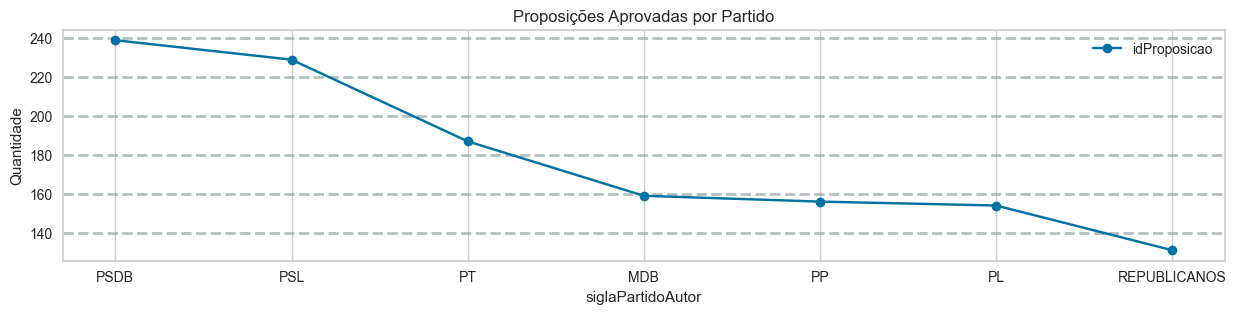

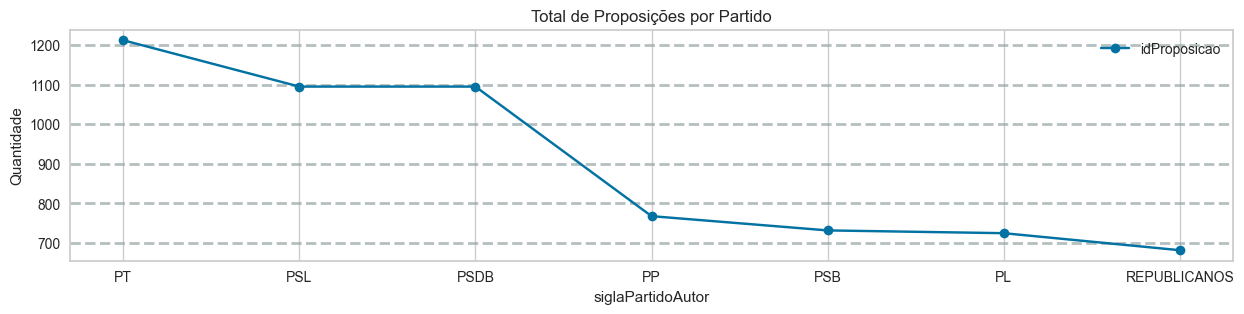

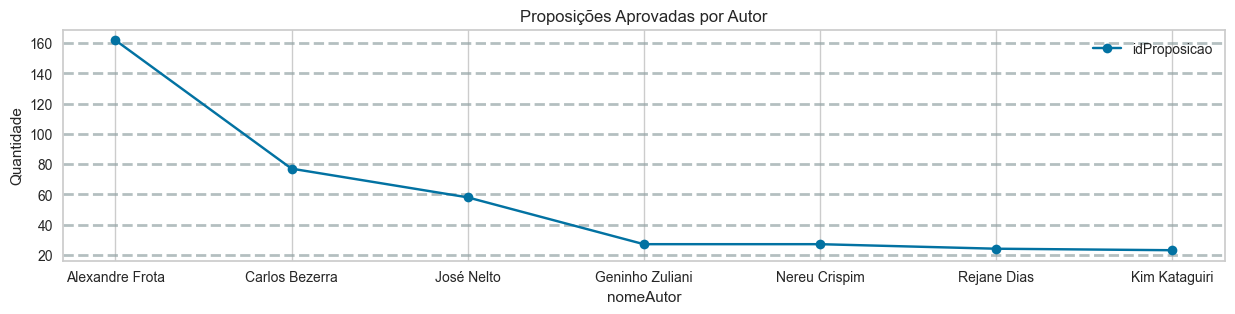

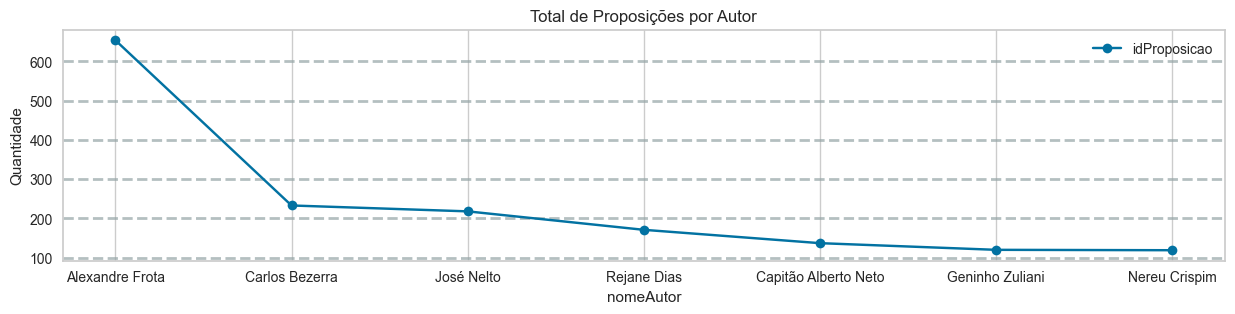

In [37]:
df_partidos_aprovados = proposicoes_aprovadas[['siglaPartidoAutor','idProposicao']].groupby(by=['siglaPartidoAutor']).count()
df_partidos_aprovados = df_partidos_aprovados.sort_values(by='idProposicao', ascending=False)
print(df_partidos_aprovados.shape)

df_autor_aprovados = proposicoes_aprovadas[['nomeAutor','idProposicao']].groupby(by=['nomeAutor']).count()
df_autor_aprovados = df_autor_aprovados.sort_values(by='idProposicao', ascending=False)
print(df_autor_aprovados.shape)

df_partidos_total = proposicoes_prepared[['siglaPartidoAutor','idProposicao']].groupby(by=['siglaPartidoAutor']).count()
df_partidos_total = df_partidos_total.sort_values(by='idProposicao', ascending=False)
print(df_partidos_total.shape)

df_autor_total = proposicoes_prepared[['nomeAutor','idProposicao']].groupby(by=['nomeAutor']).count()
df_autor_total = df_autor_total.sort_values(by='idProposicao', ascending=False)
print(df_autor_total.shape)

llama.GraphicCreator.line_graphic(title='Proposições Aprovadas por Partido', xlabel='Partido', ylabel='Quantidade', data=df_partidos_aprovados.iloc[0:7], figsize=(15,3))
llama.GraphicCreator.line_graphic(title='Total de Proposições por Partido', xlabel='Partido', ylabel='Quantidade',  data=df_partidos_total.iloc[0:7], figsize=(15,3))
llama.GraphicCreator.line_graphic(title='Proposições Aprovadas por Autor', xlabel='Autor', ylabel='Quantidade',  data=df_autor_aprovados.iloc[0:7], figsize=(15,3))
llama.GraphicCreator.line_graphic(title='Total de Proposições por Autor', xlabel='Autor', ylabel='Quantidade',  data=df_autor_total.iloc[0:7], figsize=(15,3))

**Resultado:** 

Podemos observar nos gráficos algumas informações interessantes que podem ser considerados indícios de um viés:
- Dois deputados destacam-se dos demais, tanto por total de proposições como quantidade de proposições aprovadas, que são o Alexandre Frota e o Carlos Bezerra.
- Em termos de partidos com mais aprovações destamcam-se o PSDB e o PSL, ficando o PT, em terceiro lugar, um pouco mais abaixo e os demais muito distantes dos 3 primeiros.
- Em termos de partidos com mais proposições apresentadas destacam-se o PT, PSL e PSDB. Porém, o percentual de aproveitamento do PSDB e do PSL é bem maior, pois aprovam um maior percentual das proposições com relação ao total geral de sua autoria.

In [38]:
percentual_aprovacao = pd.DataFrame(
    index=df_partidos_aprovados.iloc[0:3].index,
    data={
        'Aprovações': [
            df_partidos_aprovados.iloc[0:1]['idProposicao'].values[0],
            df_partidos_aprovados.iloc[1:2]['idProposicao'].values[0],
            df_partidos_aprovados.iloc[2:3]['idProposicao'].values[0]
        ],
        'Total Proposições': [
            df_partidos_total.iloc[2]['idProposicao'],
            df_partidos_total.iloc[1]['idProposicao'],
            df_partidos_total.iloc[0]['idProposicao']
        ]
    }
)
percentual_aprovacao['Percentual Aprovação'] = round(percentual_aprovacao['Aprovações']*100/percentual_aprovacao['Total Proposições'])
percentual_aprovacao = percentual_aprovacao.sort_values(by='Percentual Aprovação', ascending=False)
percentual_aprovacao

,Aprovações,Total Proposições,Percentual Aprovação
siglaPartidoAutor,,,
PSDB,239,1095,22.0
PSL,229,1095,21.0
PT,187,1212,15.0


<Axes: xlabel='siglaPartidoAutor'>

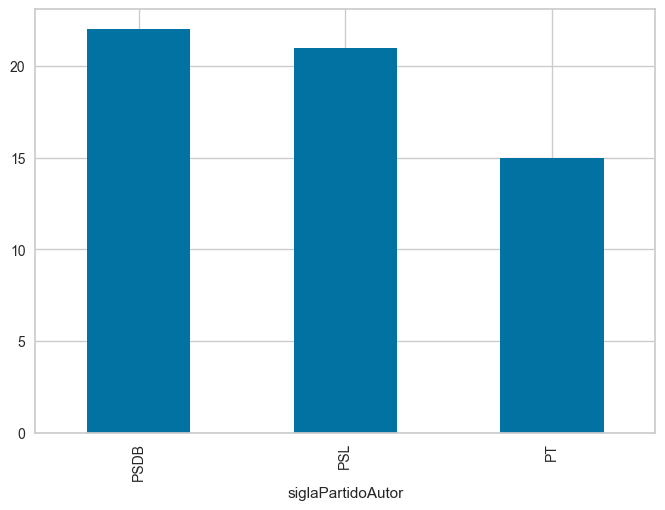

In [39]:
percentual_aprovacao['Percentual Aprovação'].plot.bar()

## Separação dos dados (treino/teste)

Separação dos dados entre três bases, sendo uma para treino e outra para testes dos modelos de ML a serem avaliados.

In [40]:
proposicoes_labeld = pd.concat([proposicoes_aprovadas, proposicoes_reprovadas])
proposicoes_labeld = proposicoes_labeld.reset_index()
print(f"Valores de aprovação: {proposicoes_labeld['aprovacao'].unique()}")
proposicoes_labeld.shape

Valores de aprovação: [1 2]


(3277, 13)

In [41]:
data_ml = [pd.DataFrame(matrix.toarray()) for matrix in np.array(proposicoes_labeld['tf_idf'])]
data_ml = pd.concat(data_ml, ignore_index=True, axis=0)
data_ml['idProposicao'] = proposicoes_labeld['idProposicao']
data_ml.reset_index()
data_ml

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,idProposicao
0,0.0,0.0,0.0,0.05836,0.161772,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,202032
1,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2020331
2,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2020559
3,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2020560
4,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2020565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2022536
3273,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2022593
3274,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2022689
3275,0.0,0.0,0.0,0.00000,0.519388,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2022816


In [42]:
data_ml = pd.merge(
    proposicoes_labeld[['codTipo','codTipoAutor','idDeputadoAutor','codigoPartidoAutor','aprovacao','idProposicao']], 
    data_ml, on='idProposicao'
)

print(f"Target variable: {data_ml['aprovacao'].unique()}")
print(data_ml.shape)
data_ml.head()

Target variable: [1 2]
(3277, 351)


,codTipo,codTipoAutor,idDeputadoAutor,codigoPartidoAutor,aprovacao,idProposicao,0,1,2,3,...,335,336,337,338,339,340,341,342,343,344
0,136,30000.0,0.0,1,1,202032,0.0,0.0,0.0,0.05836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,139,30000.0,0.0,1,1,2020331,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,139,2.0,0.0,1,1,2020559,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,139,2.0,0.0,1,1,2020560,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,139,2.0,0.0,1,1,2020565,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Experimento utilizando Rede Neural

Vamos realizar o treinamento de um modelo utilizando uma rede neural para avaliar os resultados posteriormente.

### Treinamento da rede

Vamos realizar primeiro a configuração e treinamento da rede neural.

In [43]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import coo_matrix

categories = pd.DataFrame(data_ml['aprovacao'])
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(categories)
ohe_treino = one_hot_encoder.transform(categories)
data_treino = coo_matrix(data_ml.drop(columns=['idProposicao', 'aprovacao']))
print(data_treino.shape, ohe_treino.shape)

# Setting Random Seeds:
random_seed = 33
np.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

# Formating Net
net = Sequential()
net.add(Dense(units=8, kernel_initializer='uniform', activation=activations.relu, input_dim=data_treino.shape[1]))
net.add(Dense(units=6, kernel_initializer='uniform', activation=activations.relu))
net.add(Dense(units=4, kernel_initializer='uniform', activation=activations.relu))
net.add(Dense(units=2, kernel_initializer='uniform', activation=activations.sigmoid))

# Cooking
net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
net.fit(data_treino, ohe_treino, batch_size=10, epochs=4)

(3277, 349) (3277, 2)
Epoch 1/4
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - accuracy: 0.6736 - loss: 0.6525
Epoch 2/4
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.6748 - loss: 0.6349
Epoch 3/4
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.6748 - loss: 0.6337
Epoch 4/4
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.6748 - loss: 0.6322


### Perda ao Longo das Épocas:

Vamos observar a taxa de erro ao longo do processamento conforme as épocas do treinamento.

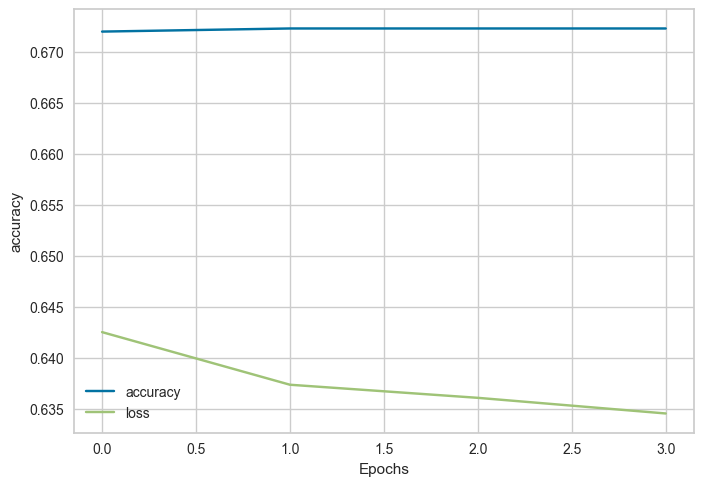

In [44]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['loss'])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'loss'])
  plt.show()
  
plot_graphs(net.history, "accuracy")

**Resultado:** Após tentar diversas combinações de neurônios e camadas, a configuração de 4 camadas com 8, 6, 4 e 2 neurônios, respectivamente, foi a que alcançou melhor resultado com menos épocas.

### Classificação com a massa de dados nova:

Será feita a classificação da massa de dados separada e que não possui um estado conhecido sobre a aprovação da proposição.

#### Separação das preposições indefinidas

Vamos separar a massa de dados que não possui uma definição sobre a aprovação ou não da proposição.

In [45]:
unseen = [pd.DataFrame(matrix.toarray()) for matrix in np.array(proposicoes_indefinidas['tf_idf'])]
unseen = pd.concat(unseen, ignore_index=True, axis=0)
unseen['idProposicao'] = proposicoes_indefinidas['idProposicao']
unseen.reset_index()

unseen = pd.merge(
    proposicoes_indefinidas[['codTipo','codTipoAutor','idDeputadoAutor','codigoPartidoAutor','idProposicao']],
    unseen, on='idProposicao'
).drop(columns=['idProposicao'])

print(unseen.shape)
unseen.head()

(5635, 349)


,codTipo,codTipoAutor,idDeputadoAutor,codigoPartidoAutor,0,1,2,3,4,5,...,335,336,337,338,339,340,341,342,343,344
0,136,40000.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,139,30000.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,139,2.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,136,40000.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,139,30000.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Predição

Faremos a predição com o modelo a partir dos dados não rotulados.

In [46]:
prediction_massa_teste = net.predict(coo_matrix(unseen))
prediction_massa_teste

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


array([[0.63378596, 0.3696128 ],
       [0.63378596, 0.3696128 ],
       [0.7831418 , 0.22826606],
       ...,
       [0.76980805, 0.23179932],
       [0.6321039 , 0.36675408],
       [0.7697608 , 0.23184583]], dtype=float32)

#### Interpretando a saída

O resultado é um array contendo a probabilidade de que a proposição seja aprovada (primeira posição) ou reprovada (segunda posição). A soma sempre será igual a 1, que representa 100%.

Vamos separar as proposições com 70% ou mais de chance de obter aprovação para considerar como tendo potencial de aprovação e, então, apresentar os resultados.

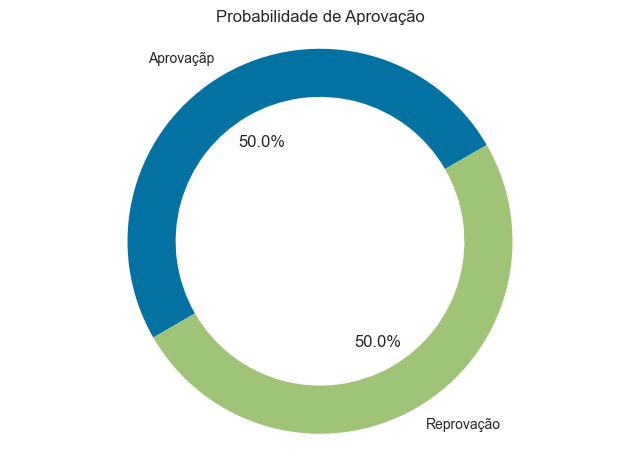

In [47]:
df_result = pd.DataFrame(prediction_massa_teste, columns=['Aprovado','Reprovado'])
df_result['resultado'] = df_result['Aprovado'].apply(lambda x: 1 if x > 0.7 else 2)
df_result[['Aprovado','resultado']].groupby(by=['resultado']).count()

llama.GraphicCreator.pie_graphic(
    title='Probabilidade de Aprovação',
    data={
      'Aprovaçãp': df_result['Aprovado'].tolist()[0],
      'Reprovação': df_result['Aprovado'].tolist()[1]
    }
)

**Resultado:** A massa ficou bem dividida, provavelmente resultado do desbalanceamento das classes que não foi tratado antes. Por isso compensei no critério de 70% ou mais de probabilidade.

## Experimento utilizando modelos com Pycaret

O Pycaret é uma biblioteca de ML do tipo low code que permite comparar rapidamente vários modelos diferentes e avaliar o desempenho destes modelos de forma rápida e prática, proporcionando alta produtividade. Vamos experimentar, a seguir, alguns recursos desta biblioteca.

### Setup

Para começar a utilizar o Pycaret basta utilizar o método setup, conforme a seguir.

In [48]:
setup = setup(
    data = data_ml.drop(columns=['idProposicao']),
    target = 'aprovacao',
    session_id=123, 
)

,Description,Value
0,Session id,123
1,Target,aprovacao
2,Target type,Binary
3,Target mapping,"1: 0, 2: 1"
4,Original data shape,"(3277, 350)"
5,Transformed data shape,"(3277, 350)"
6,Transformed train set shape,"(2293, 350)"
7,Transformed test set shape,"(984, 350)"
8,Numeric features,349
9,Preprocess,True


### Comparação entre modelos

Abaxo a comparação entre diversos modelos e os melhores resultados de cada um em destaque. Podemos escolher o melhor modelo para nosso problema de acordo com a métrica que for mais adequada para ele.

In [49]:
compare_models()

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

**Resultado:** Como pode ser observado na tabela acima, o Extra Trees Classifier apresenta melhor desempenho em todas as métricas. Logo, será nossa escolha.

### Avaliando o modelo escolhido

Como o ET apresentou o melhor resultado em todas as métricas, vamos escolher este modelo para prosseguir a análise.

In [50]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7696,0.8204,0.7696,0.7642,0.7656,0.4631,0.4651
1,0.7783,0.7923,0.7783,0.7748,0.7632,0.4493,0.4698
2,0.8130,0.8910,0.8130,0.8089,0.8088,0.5579,0.5615
3,0.7511,0.7510,0.7511,0.7412,0.7403,0.3957,0.4039
4,0.7642,0.8197,0.7642,0.7579,0.7595,0.4457,0.4481
5,0.8384,0.8596,0.8384,0.8365,0.8332,0.6134,0.6210
6,0.8297,0.8527,0.8297,0.8266,0.8251,0.5954,0.6009
7,0.8210,0.8377,0.8210,0.8202,0.8121,0.5621,0.5768
8,0.7991,0.7878,0.7991,0.7945,0.7951,0.5278,0.5306


### Avaliação com curva ROC

Vemos abaixo que os resultados estão bons, mantendo as duas classes próximas de 1.

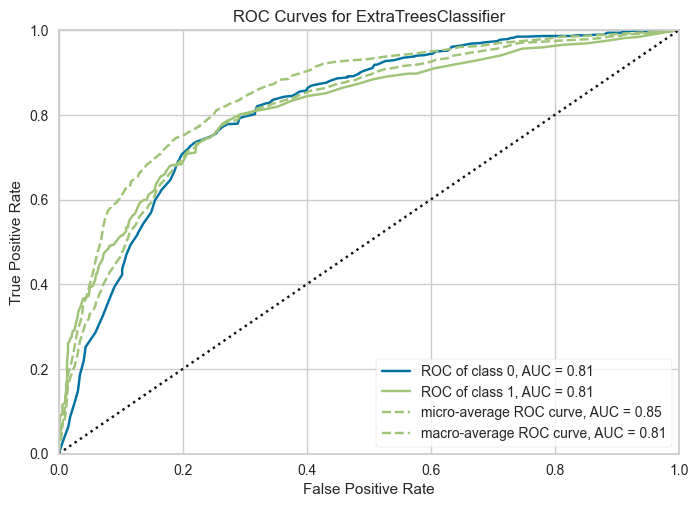

In [51]:
plot_model(et, plot = 'auc')

### Avaliação de features

Abaixo podemos observar que, como esperado, o autor (idDeputadoAutor) e também o partido (codigoPartidoAutor) exercem bastante influência no resultado final. As demais features, por sua posição no conjunto, são palavras da ementa ou da lista de palavras chave.

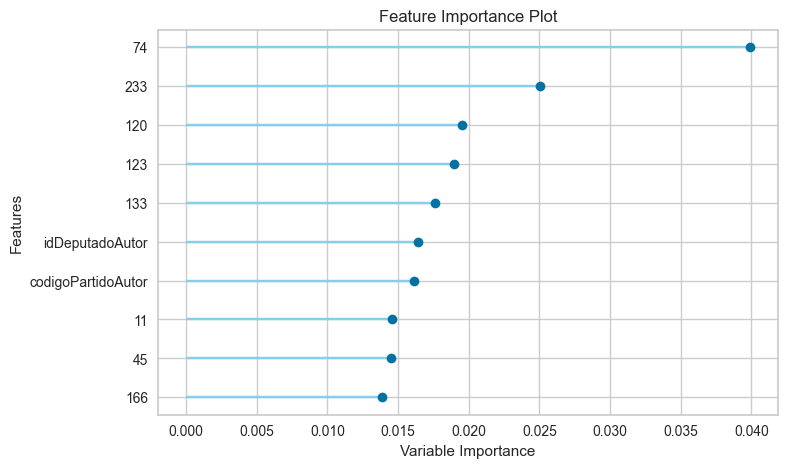

In [52]:
plot_model(et, plot='feature')

In [53]:
vocabulary[[74, 233, 120, 123, 133, 11, 45, 166]]

array(['coronavru', 'pandem', 'emergnc', 'energ', 'espi', 'altera',
       'calam', 'importnc'], dtype=object)

**Resultado:** Podemos ver que o autor (deputado), o partido e palavras chaves ligadas a pandemia de COVID 19 são as features mais relevantes do problema. O que demonstra um comportamento profundamente ligado ao período analisado que foi o período do auge da pandemia (2020 a 2022).

### Avaliação com a matriz de confusão

A Matrix de Confusão permite avaliar graficamente as principais métricas de classificação.

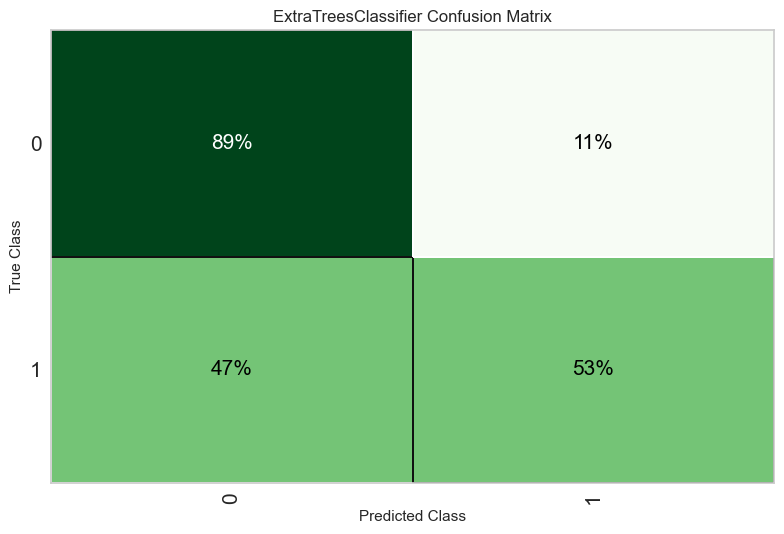

In [54]:
plot_model(et, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

### Class Prediction Error

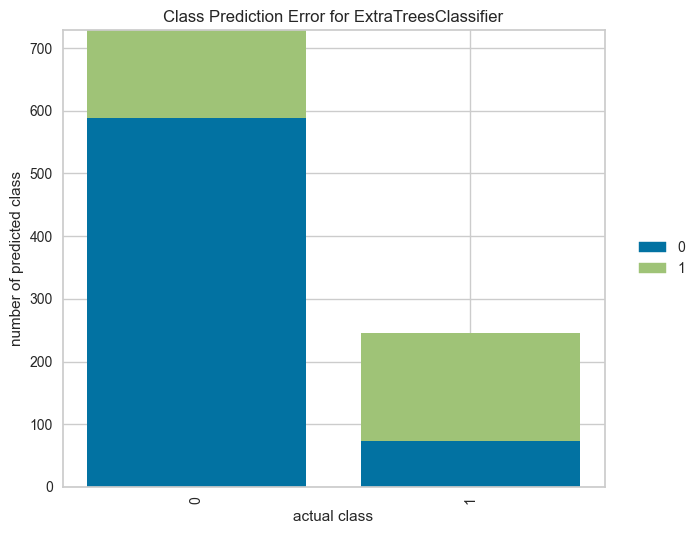

In [55]:
plot_model(et, plot = 'error')

### Finalizando e aplicando modelo

A seguir, vamos finalizar o modelo e aplicá-lo em novas preposições que ainda não têm um resultado final (aprovação ou reprovação).

In [56]:
finalized_model = finalize_model(et)
print(finalized_model)

Pipeline(memory=Memory(location=None),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['codTipo', 'codTipoAutor',
                                             'idDeputadoAutor',
                                             'codigoPartidoAutor', '0', '1',
                                             '2', '3', '4', '5', '6', '7', '8',
                                             '9', '10', '11', '12', '13', '14',
                                             '15', '16', '...
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='sqrt',
                               

In [57]:
predictions = predict_model(finalized_model, data=unseen)
predictions.head()

,codTipo,codTipoAutor,idDeputadoAutor,codigoPartidoAutor,0,1,2,3,4,5,...,337,338,339,340,341,342,343,344,prediction_label,prediction_score
0,136,40000.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.54
1,139,30000.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.86
2,139,2.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.91
3,136,40000.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.54
4,139,30000.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.57


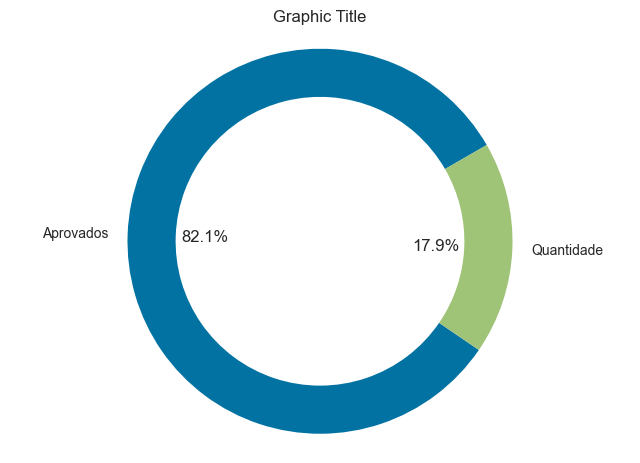

In [58]:
result = predictions[['prediction_label','codTipo']].groupby(by='prediction_label').count()
llama.GraphicCreator.pie_graphic(data={
    'Aprovados': result['codTipo'].tolist()[0],
    'Quantidade': result['codTipo'].tolist()[1]
})

## Conclusão

Foi necessário fazer um longo e moroso trabalho de exploração de dados e de pesquisa sobre os conceitos ligados ao tema, principalmente para o entendimento de quais estados indicam aprovação, quais indicam reprovação e quais indicam que a proposição ainda está em tramitação. A dificuldade na determinação desse critério levou à muitas idas e vindas, tornando o trabalho mais longo que o esperado e conduzindo à muitas conclusões parciais equivocadas - e consequente reavaliação constante de todo código. Mas isso é comum em se tratando de trabalho de pesquisa, principalmente com fonte de dados desconhecida.

Tentei realizar todo o trabalho com a biblioteca Pycaret, uma lib low code com uma proposta muito interessante. Porém, na parte de anlálise exploratória e tratamento de dados a lib deixa bastante a desejar. Logo, foi necessário incluir muitos outros recursos e até um código que eu já venho desenvolvendo há algum tempo para objetivo semelhante. Ainda assim, a lib Pycaret mostrou-se bastante útil, principalmente na comparação de modelos. Embora os critérios dessa comparação não estejam muito claros e evidentes, dá ótimos indícios de em quais modelos investir melhor. A Pycaret possui ainda recursos de otimização que, por falta de tempo, não cheguei a explorar.

Contudo, ao colocar o código no Colab, a lib Pycaret apresentou inúmeros conflitos com bibliotecas já carregadas automaticamente no ambiente do Colab. Tentei diversos meios para resolver o problema e perdi muitas horas, porém sem sucesso. Entre as tratativas, tentei instalar o Pycaret num ambiente isolado, mas o Colab têm restrições quanto a esta estratégia. Tentei atualizar as libs para as versões mais atuais, novamente o Colab restringiu minha ação. Com o prazo terminando, resolvi retirar o Pycaret e entregar sem esta parte. Porém, vou disponibilizar o código completo no GitHub [neste link](https://github.com/edprata/proposicoes_camara_deputados/tree/main).

Sobre a parte de rede neural, foi bastante simples o uso do Sklearn. Após poucas tentativas já começou a produzir bons resultados. Isso aconteceu a partir do momento que utilizei 4 camadas, com 3 o resultado não foi bom. Sequer foi necessário uso de muitos neurônios. A função sigmoid e o uso de 2 neurônios na última camada foi utilizada para produzir a saída de acordo com a quantidade de classes do problema (aprovado ou reprovado).

Sobre os resultados da análise dos dados e dos modelos, pude confirmar a hipótese de que o autor e o partido político exercem uma forte influência sobre a aprovação ou não da proposição. Também foi possível encontrar, na análise de relevâncias das features, um viés claro relacionado ao evento mais importante do período analisado, que foi a Pandemia de COVID 16. Isso demonstra o quanto o trabalho de legislar é influenciado sobre questões sociais, a mídia e a opinião pública. Apesar de tantas alterações na legislatura, sabemos que o resultado do combate à pandemia foi desastroso e também sabemos que crises sanitárias não podem ser resolvidas por uma grande alterações nas leis vigentes do país, pois é uma questão médica e de saúde públic e não política.

Para finalizar, há muitas melhorias que gostaria de ter feito, porém não houve tempo hábil:
- Usar toda a massa de dados (2015 em diante) para fugir do viés causado por um evento restrito no tempo, que foi a Pandemia de COVID 19;
- Usar uma massa maior também poderia ajudar a tratar vieses relacionados a partidos políticos e de pessoas específicas da política, já que cargos mudam e eleições se ganha e se perde. Seria o caso de testar para saber se haveria eficácia nesta estratégia;
- Fazer uma análise de quais métricas seriam mais adequadas para avaliar os resultados, de acordo com a necessidade específica deste trabalho;
- Usar técnicas de tunning tanto da biblioteca Pycaret quanto outras para comparar os modelos e produzir resultados mais adequados;
- Fazer uma análise descritiva mais abrangente para tentar identificar outros vises que poderiam ser tratados. Analisei apenas as proposições aprovadas, mas gostaria de ter visto o restante do conjunto de dados;
- Testar algorítimos de regressão e classificação comparar resultados e explorar mais o uso da estimativa de probabilidade de aprovação ao invés de dizer apenas que uma proposição poderá ou não aprovada.
- Por último, tratar o desbalanceamento das classes antes do treino ao invés de compensar no percentual final de probabilidade de aprovação.